In [75]:
#read the text file dataset and convert it into csv
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import colors
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
!pip install prophet
!pip install pmdarima
from prophet import Prophet
import numpy as np
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import seasonal_decompose
!pip install neuralprophet
from neuralprophet import NeuralProphet






# #Load the dataset into a DataFrame
# dataset_path = '/content/household_power_consumption.txt'
# df = pd.read_csv(dataset_path, sep=';', parse_dates=[["Date", "Time"]], dayfirst=True)
# #Convert to CSV
# output_csv_path = 'household_power_consumption_dataset.csv'
# df.to_csv(output_csv_path, index=False)


In [76]:
df = pd.read_csv('/content/household_power_consumption_dataset.csv')
df_copy = df.copy()
df.head()


,Date_Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [77]:
# Calculate mean and standard deviation of the required columns
columns_to_analyze = ["Global_active_power", "Global_reactive_power", "Voltage", "Global_intensity", "Sub_metering_1", "Sub_metering_2", "Sub_metering_3"]

# Handle non-numeric values by converting them to NaN
df[columns_to_analyze] = df[columns_to_analyze].apply(pd.to_numeric, errors='coerce')

means = df[columns_to_analyze].mean()
std_devs = df[columns_to_analyze].std()

# Print the results
print("Mean of Different Columns:")
print(means)

print("\nStandard Deviation of Different Columns:")
print(std_devs)

print(df.describe(include='all'))

Mean of Different Columns:
Global_active_power        1.400264
Global_reactive_power      0.121508
Voltage                  240.720369
Global_intensity           5.923020
Sub_metering_1             1.205349
Sub_metering_2             1.829585
Sub_metering_3             6.611034
dtype: float64

Standard Deviation of Different Columns:
Global_active_power      1.298341
Global_reactive_power    0.112738
Voltage                  3.141472
Global_intensity         5.478759
Sub_metering_1           6.412824
Sub_metering_2           7.274617
Sub_metering_3           8.487417
dtype: float64
                  Date_Time  Global_active_power  Global_reactive_power  \
count                178861        178852.000000          178852.000000   
unique               178861                  NaN                    NaN   
top     2006-12-16 17:24:00                  NaN                    NaN   
freq                      1                  NaN                    NaN   
mean                    NaN         

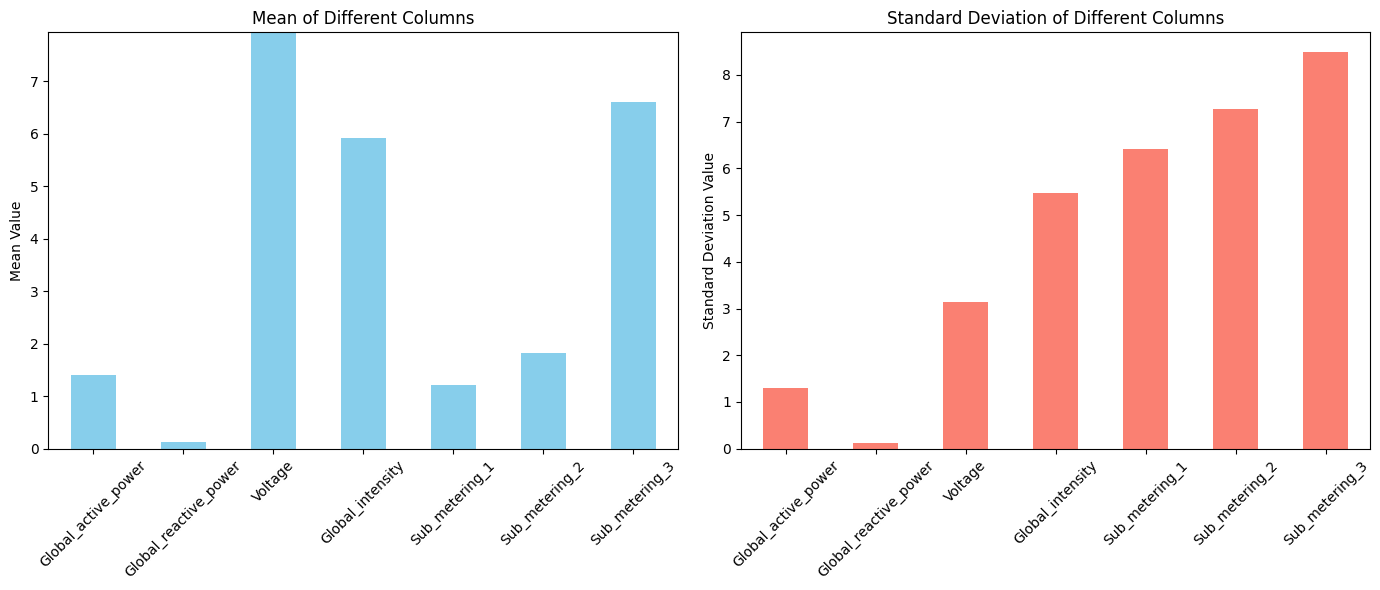

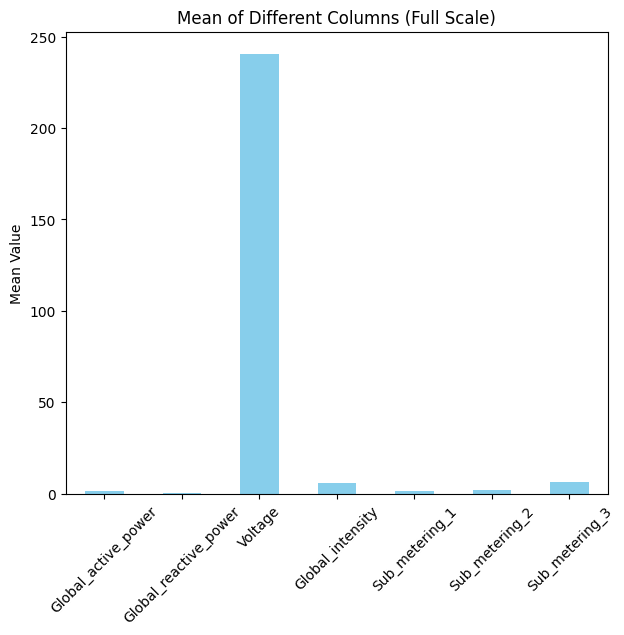

In [59]:
# Plot bar graphs for means and standard deviations
plt.figure(figsize=(14, 6))

# Mean plot with y-limit to zoom in on smaller values
plt.subplot(1, 2, 1)
means.plot(kind='bar', color='skyblue')
plt.title('Mean of Different Columns')
plt.ylabel('Mean Value')
plt.xticks(rotation=45)
plt.ylim(0, means[means < means.max()].max() * 1.2)  # Zoom in on smaller values

# Standard Deviation plot
plt.subplot(1, 2, 2)
std_devs.plot(kind='bar', color='salmon')
plt.title('Standard Deviation of Different Columns')
plt.ylabel('Standard Deviation Value')
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


# Plot bar graph for means without zooming in
plt.figure(figsize=(7, 6))
means.plot(kind='bar', color='skyblue')
plt.title('Mean of Different Columns (Full Scale)')
plt.ylabel('Mean Value')
plt.xticks(rotation=45)
plt.show()

Index(['Date_Time', 'Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')
Index(['Date_Time', 'Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')
Data range: 0 to 178860


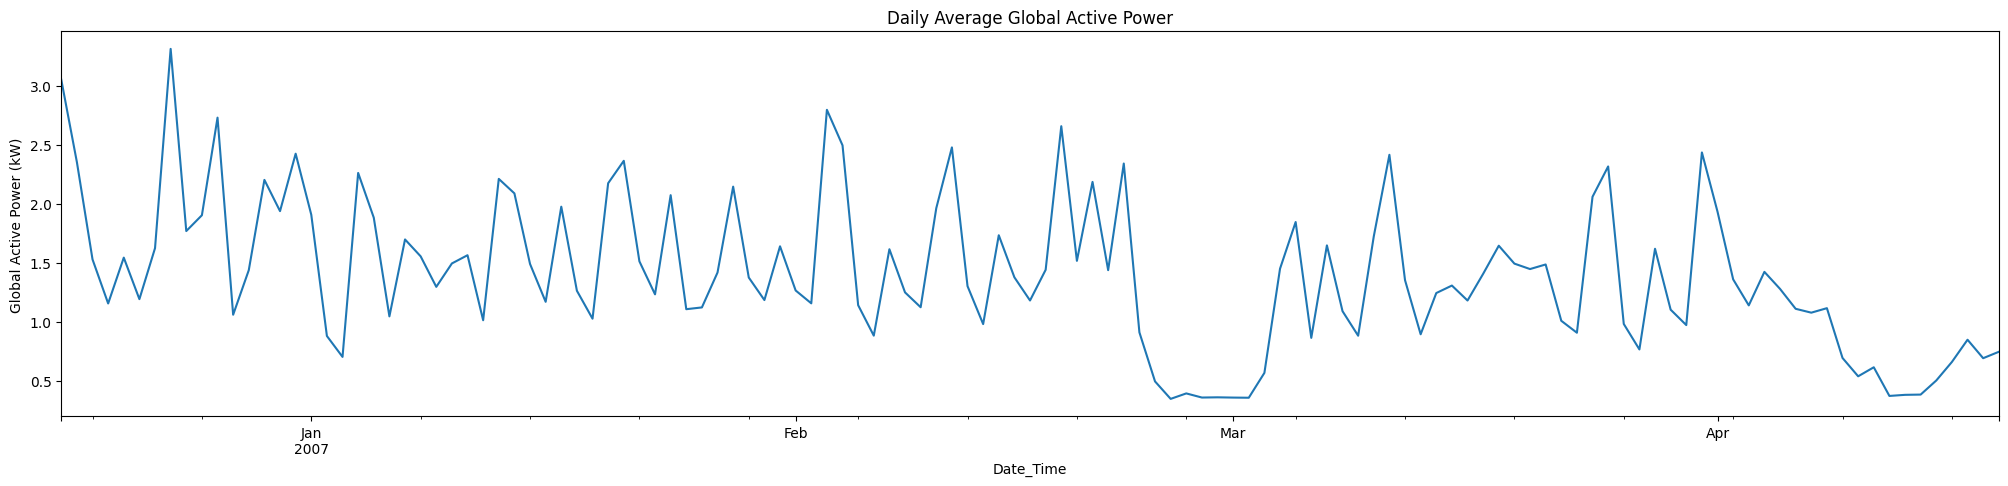

In [60]:
#time series plot
print(df.columns)
print(df_copy.columns)
print("Data range:", df_copy.index.min(), "to", df_copy.index.max())

df['Date_Time'] = pd.to_datetime(df['Date_Time'])
df_copy['Date_Time'] = pd.to_datetime(df_copy['Date_Time'])

df_copy[columns_to_analyze] = df_copy[columns_to_analyze].apply(pd.to_numeric, errors='coerce')

df_copy.set_index('Date_Time', inplace=True)
df_copy.resample('D')['Global_active_power'].mean().plot(figsize=(25, 5), title='Daily Average Global Active Power')
plt.ylabel('Global Active Power (kW)')
plt.show()


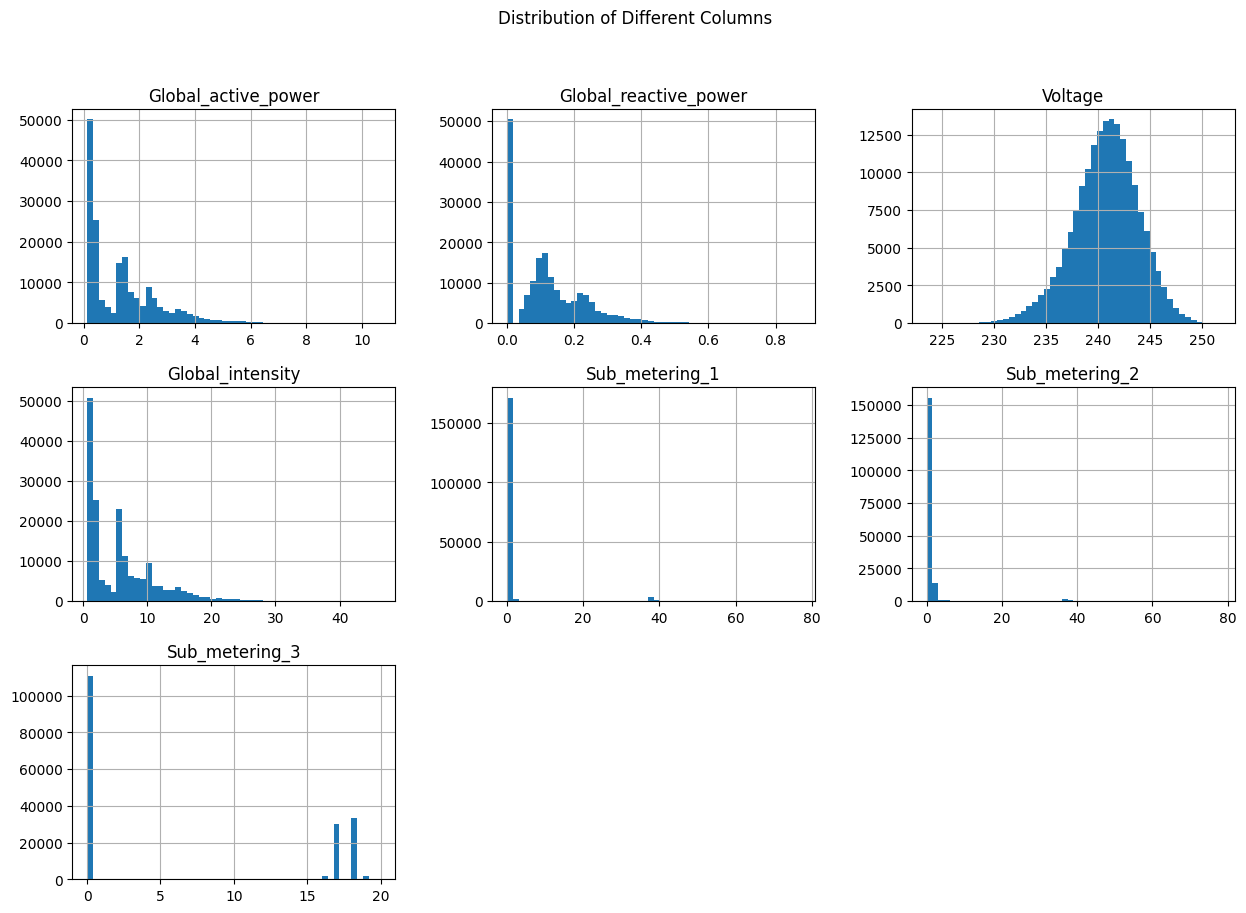

In [61]:
df[columns_to_analyze].hist(bins=50, figsize=(15, 10))
plt.suptitle('Distribution of Different Columns')
plt.show()



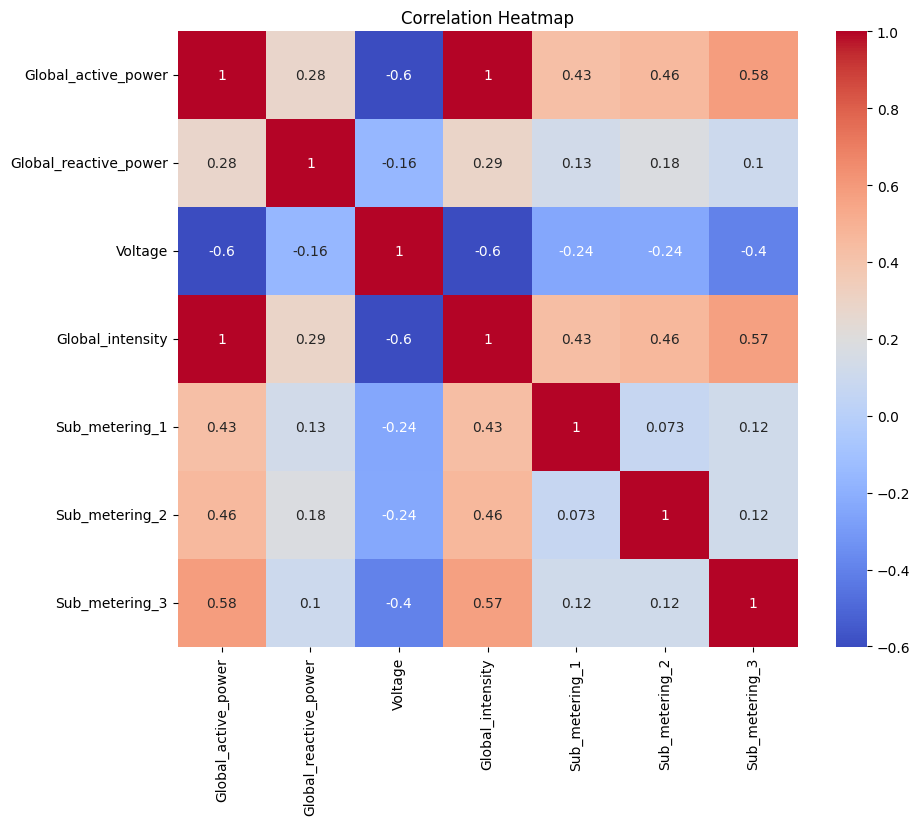

In [62]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[columns_to_analyze].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


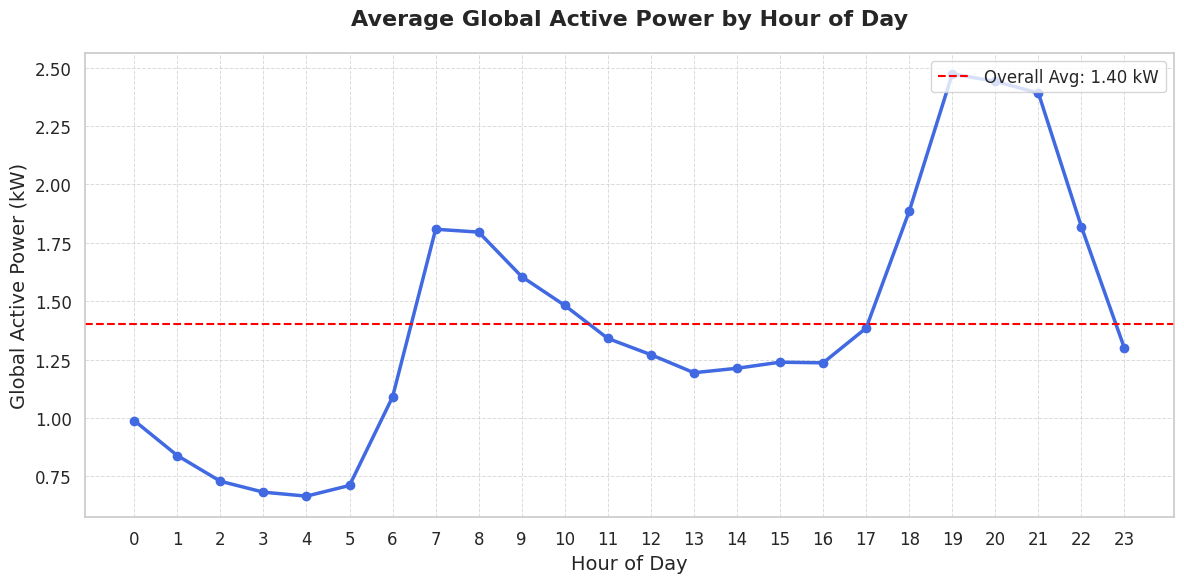

In [63]:
df['Date_Time'] = pd.to_datetime(df['Date_Time'], errors='coerce')

# Now you can extract the hour without changing the index
df['hour'] = df['Date_Time'].dt.hour

# Plotting the average Global Active Power by hour of day
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
plt.plot(df.groupby('hour')['Global_active_power'].mean(), color='royalblue', linewidth=2.5, marker='o', markersize=6)

# Add titles and labels with custom font sizes
plt.title('Average Global Active Power by Hour of Day', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Global Active Power (kW)', fontsize=14)

# Customize ticks and grid
plt.xticks(range(0, 24), fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

# Add a horizontal line for average value across all hours
avg_power = df['Global_active_power'].mean()
plt.axhline(avg_power, color='red', linestyle='--', linewidth=1.5, label=f'Overall Avg: {avg_power:.2f} kW')

# Add legend and improve layout
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

In [64]:
# # Convert Date_Time to datetime and set as index
# print(df.columns)
# df['Date_Time'] = pd.to_datetime(df['Date_Time'])
# df.set_index('Date_Time', inplace=True)

# # Drop Sub_metering columns that could create bias
# df.drop(['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'], axis=1, inplace=True)

# # Forward fill missing values
# df.fillna(method='ffill', inplace=True)

# # Split data into train (80%) and test (20%) sets
# train_size = int(len(df) * 0.8)
# train, test = df.iloc[:train_size], df.iloc[train_size:]

# # Seasonal ARIMA (SARIMA) Model
# def fit_sarima(train, test):
#     # Fit SARIMA model
#     order = (1, 1, 1)
#     seasonal_order = (1, 1, 1, 12)
#     sarima_model = SARIMAX(train['Global_active_power'], order=order, seasonal_order=seasonal_order)
#     sarima_result = sarima_model.fit()

#     # Forecast for test set
#     sarima_forecast = sarima_result.get_forecast(steps=len(test)).predicted_mean

#     # Evaluate model
#     mae = mean_absolute_error(test['Global_active_power'], sarima_forecast)
#     rmse = np.sqrt(mean_squared_error(test['Global_active_power'], sarima_forecast))
#     r2 = r2_score(test['Global_active_power'], sarima_forecast)

#     print(f'SARIMA - MAE: {mae}, RMSE: {rmse}, R²: {r2}')
#     return sarima_forecast

# # Long Short-Term Memory (LSTM) Model
# def fit_lstm(train, test):
#     # Prepare data for LSTM
#     def create_lstm_dataset(data, look_back=1):
#         X, y = [], []
#         for i in range(len(data) - look_back - 1):
#             a = data[i:(i + look_back), 0]
#             X.append(a)
#             y.append(data[i + look_back, 0])
#         return np.array(X), np.array(y)

#     # Normalize the data for LSTM
#     from sklearn.preprocessing import MinMaxScaler
#     scaler = MinMaxScaler(feature_range=(0, 1))
#     train_scaled = scaler.fit_transform(train[['Global_active_power']])
#     test_scaled = scaler.transform(test[['Global_active_power']])

#     look_back = 60  # Use last 60 time steps (minutes)
#     X_train, y_train = create_lstm_dataset(train_scaled, look_back)
#     X_test, y_test = create_lstm_dataset(test_scaled, look_back)

#     # Reshape input to be [samples, time steps, features]
#     X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#     X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

#     # Define LSTM model
#     lstm_model = Sequential()
#     lstm_model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
#     lstm_model.add(LSTM(50))
#     lstm_model.add(Dropout(0.2))
#     lstm_model.add(Dense(1))
#     lstm_model.compile(optimizer='adam', loss='mean_squared_error')

#     # Train LSTM model
#     lstm_model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=1)

#     # Make predictions
#     lstm_predictions = lstm_model.predict(X_test)
#     lstm_predictions = scaler.inverse_transform(lstm_predictions)

#     # Evaluate model
#     mae = mean_absolute_error(test[look_back+1:]['Global_active_power'], lstm_predictions)
#     rmse = np.sqrt(mean_squared_error(test[look_back+1:]['Global_active_power'], lstm_predictions))
#     r2 = r2_score(test[look_back+1:]['Global_active_power'], lstm_predictions)

#     print(f'LSTM - MAE: {mae}, RMSE: {rmse}, R²: {r2}')
#     return lstm_predictions

# # Prophet Model
# def fit_prophet(train, test):
#     # Prepare data for Prophet
#     prophet_train = train.reset_index()[['Date_Time', 'Global_active_power']].rename(columns={'Date_Time': 'ds', 'Global_active_power': 'y'})
#     prophet_test = test.reset_index()[['Date_Time', 'Global_active_power']].rename(columns={'Date_Time': 'ds', 'Global_active_power': 'y'})

#     # Fit Prophet model
#     prophet_model = Prophet(yearly_seasonality=True, daily_seasonality=True)
#     prophet_model.fit(prophet_train)

#     # Forecast
#     future = prophet_model.make_future_dataframe(periods=len(test))
#     forecast = prophet_model.predict(future)
#     prophet_forecast = forecast['yhat'][-len(test):].values

#     # Evaluate model
#     mae = mean_absolute_error(prophet_test['y'], prophet_forecast)
#     rmse = np.sqrt(mean_squared_error(prophet_test['y'], prophet_forecast))
#     r2 = r2_score(prophet_test['y'], prophet_forecast)

#     print(f'Prophet - MAE: {mae}, RMSE: {rmse}, R²: {r2}')
#     return prophet_forecast

# # Perform Time Series Split for Cross-Validation
# # tscv = TimeSeriesSplit(n_splits=2)
# # for train_index, test_index in tscv.split(df):
# #     cv_train, cv_test = df.iloc[train_index], df.iloc[test_index]

# #     print("SARIMA Model:")
# #     sarima_forecast = fit_sarima(cv_train, cv_test)

# #     print("\nLSTM Model:")
# #     lstm_forecast = fit_lstm(cv_train, cv_test)

# #     print("\nProphet Model:")
# #     prophet_forecast = fit_prophet(cv_train, cv_test)

# #     print("="*50)

# print("SARIMA Model:")
# sarima_forecast = fit_sarima(train, test)

# print("\nLSTM Model:")
# lstm_forecast = fit_lstm(train, test)

# print("\nProphet Model:")
# prophet_forecast = fit_prophet(train, test)

# print("="*50)

# Convert Date_Time to datetime and set as index
print(df.columns)
df['Date_Time'] = pd.to_datetime(df['Date_Time'])
df.set_index('Date_Time', inplace=True)

# Set frequency to 1 minute ('T' for minute frequency)
df = df.asfreq('T')

# Drop Sub_metering columns that could create bias
df.drop(['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'], axis=1, inplace=True)

# Forward fill missing values
df.ffill(inplace=True)  # Updated to use ffill()

# Split data into train (80%) and test (20%) sets
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

df.to_csv('final_dataset.csv', index=False)

"""
# Seasonal ARIMA (SARIMA) Model
def fit_sarima(train, test):
    # Fit SARIMA model
    order = (1, 1, 1)
    seasonal_order = (1, 1, 1, 12)
    sarima_model = SARIMAX(train['Global_active_power'], order=order, seasonal_order=seasonal_order)
    sarima_result = sarima_model.fit()

    # Forecast for test set
    sarima_forecast = sarima_result.get_forecast(steps=len(test)).predicted_mean

    # Evaluate model
    mae = mean_absolute_error(test['Global_active_power'], sarima_forecast)
    rmse = np.sqrt(mean_squared_error(test['Global_active_power'], sarima_forecast))
    r2 = r2_score(test['Global_active_power'], sarima_forecast)

    print(f'SARIMA - MAE: {mae}, RMSE: {rmse}, R²: {r2}')
    return sarima_forecast
"""
"""
# Automatically find the best SARIMA model using auto_arima
def fit_auto_sarima(train, test):
    # Fit SARIMA model automatically
    smodel = pm.auto_arima(train['Global_active_power'], seasonal=True, m=12, stepwise=True, trace=True)
    print(smodel.summary())

    # Forecast for test set
    sarima_forecast = smodel.predict(n_periods=len(test))

    # Evaluate model
    mae = mean_absolute_error(test['Global_active_power'], sarima_forecast)
    rmse = np.sqrt(mean_squared_error(test['Global_active_power'], sarima_forecast))
    r2 = r2_score(test['Global_active_power'], sarima_forecast)

    print(f'SARIMA (Auto) - MAE: {mae}, RMSE: {rmse}, R²: {r2}')
    return sarima_forecast
"""


# Seasonal naive forecast (use last season's values as the forecast)
def seasonal_naive_forecast(train, test, seasonal_period):
    last_season = train['Global_active_power'][-seasonal_period:]
    forecast = np.tile(last_season.values, int(np.ceil(len(test) / seasonal_period)))[:len(test)]

    # Evaluation
    mse = mean_squared_error(test['Global_active_power'], forecast)
    rmse = np.sqrt(mse)
    r2 = r2_score(test['Global_active_power'], forecast)

    print(f'Seasonal Naive - MSE: {mse}, RMSE: {rmse}, R²: {r2}')

    model_metrics["Model"].append('Seasonal Naive')
    model_metrics["MSE"].append(mse)
    model_metrics["RMSE"].append(rmse)
    model_metrics["R2"].append(r2)

    return forecast


# Long Short-Term Memory (LSTM) Model
def fit_lstm(train, test):
    # Prepare data for LSTM
    def create_lstm_dataset(data, look_back=1):
        X, y = [], []
        for i in range(len(data) - look_back - 1):
            a = data[i:(i + look_back), 0]
            X.append(a)
            y.append(data[i + look_back, 0])
        return np.array(X), np.array(y)

    # Normalize the data for LSTM
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train[['Global_active_power']])
    test_scaled = scaler.transform(test[['Global_active_power']])

    look_back = 60  # Use last 60 time steps (minutes)
    X_train, y_train = create_lstm_dataset(train_scaled, look_back)
    X_test, y_test = create_lstm_dataset(test_scaled, look_back)

    # Reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Define LSTM model
    lstm_model = Sequential()
    lstm_model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
    lstm_model.add(LSTM(50))
    lstm_model.add(Dropout(0.2))
    lstm_model.add(Dense(1))
    lstm_model.compile(optimizer='adam', loss='mean_squared_error')

    # Train LSTM model
    lstm_model.fit(X_train, y_train, epochs=3, batch_size=256, verbose=1)

    # Make predictions
    lstm_predictions = lstm_model.predict(X_test)
    lstm_predictions = scaler.inverse_transform(lstm_predictions)

    # Align LSTM predictions with test data
    actual_test = test['Global_active_power'].iloc[look_back+1:].values
    lstm_predictions = lstm_predictions[:len(actual_test)]  # Match lengths

    # Evaluate model
    mae = mean_absolute_error(actual_test, lstm_predictions)
    mse = mean_squared_error(actual_test, lstm_predictions)
    rmse = np.sqrt(mean_squared_error(actual_test, lstm_predictions))
    r2 = r2_score(actual_test, lstm_predictions)

    model_metrics["Model"].append('LSTM')
    model_metrics["MSE"].append(mse)
    model_metrics["RMSE"].append(rmse)
    model_metrics["R2"].append(r2)

    print(f'LSTM - MAE: {mae}, RMSE: {rmse}, R²: {r2}')
    return lstm_predictions

model_metrics = {
    "Model": [],
    "MSE": [],
    "RMSE": [],
    "R2": []
}

def fit_prophet(train, test):
    # Prepare data for Prophet
    prophet_train = train.reset_index()[['Date_Time', 'Global_active_power']].rename(columns={'Date_Time': 'ds', 'Global_active_power': 'y'})
    prophet_test = test.reset_index()[['Date_Time', 'Global_active_power']].rename(columns={'Date_Time': 'ds', 'Global_active_power': 'y'})

    # Fit Prophet model
    prophet_model = Prophet(yearly_seasonality=True, daily_seasonality=True)
    prophet_model.fit(prophet_train)

    # Forecast only for the test period, and set frequency to 'T' for minutes
    future = prophet_model.make_future_dataframe(periods=len(test), freq='T')

    # Predict future values
    forecast = prophet_model.predict(future)

    # Get predictions for the test period
    prophet_forecast = forecast['yhat'][-len(test):].values

    # Evaluate model
    mae = mean_absolute_error(prophet_test['y'], prophet_forecast)
    rmse = np.sqrt(mean_squared_error(prophet_test['y'], prophet_forecast))
    r2 = r2_score(prophet_test['y'], prophet_forecast)



    print(f'Prophet - MAE: {mae}, RMSE: {rmse}, R²: {r2}')
    return prophet_forecast

def fit_neural_prophet(train, test):
    # Prepare the data in Prophet format with 'ds' and 'y' columns
    prophet_train = train.reset_index()[['Date_Time', 'Global_active_power']].rename(columns={'Date_Time': 'ds', 'Global_active_power': 'y'})
    prophet_test = test.reset_index()[['Date_Time', 'Global_active_power']].rename(columns={'Date_Time': 'ds', 'Global_active_power': 'y'})

    # Initialize NeuralProphet model
    model = NeuralProphet(yearly_seasonality=True, daily_seasonality=True, weekly_seasonality=True, epochs=10)

    # Fit model
    model.fit(prophet_train, freq='D')

    # Make future dataframe for forecast
    future = model.make_future_dataframe(prophet_train, periods=len(test))
    forecast = model.predict(future)

    # Extract forecasted values
    neural_prophet_forecast = forecast['yhat1'].iloc[-len(test):].values

    # Evaluate model
    mse = mean_squared_error(prophet_test['y'], neural_prophet_forecast)
    rmse = np.sqrt(mse)
    r2 = r2_score(prophet_test['y'], neural_prophet_forecast)

    print(f'NeuralProphet - MSE: {mse}, RMSE: {rmse}, R²: {r2}')
    return neural_prophet_forecast

# Example usage
#neural_prophet_forecast = fit_neural_prophet(train, test)

# Perform Time Series Split for Cross-Validation
#print("SARIMA Model:")
#sarima_forecast = fit_auto_sarima(train, test)

#seasonal naive model
seasonal_period = 43200
seasonal_forecast = seasonal_naive_forecast(train, test, seasonal_period)

#print("\nProphet Model:")
#prophet_forecast = fit_prophet(train, test)

print("\nLSTM Model:")
lstm_forecast = fit_lstm(train, test)

print("="*50)


WARNING - (py.warnings._showwarnmsg) - <ipython-input-64-a9818f2fc44e>:139: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df = df.asfreq('T')

  df = df.asfreq('T')



Index(['Date_Time', 'Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'hour'],
      dtype='object')
Seasonal Naive - MSE: 2.4552651559556087, RMSE: 1.5669285739801955, R²: -1.1475272713036393

LSTM Model:


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)

  super().__init__(**kwargs)



Epoch 1/3
559/559 ━━━━━━━━━━━━━━━━━━━━ 128s 222ms/step - loss: 0.0042
Epoch 2/3
559/559 ━━━━━━━━━━━━━━━━━━━━ 123s 220ms/step - loss: 0.0016
Epoch 3/3
559/559 ━━━━━━━━━━━━━━━━━━━━ 140s 217ms/step - loss: 0.0013
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step
LSTM - MAE: 0.13899875185467758, RMSE: 0.34120619392315793, R²: 0.8982739519125563


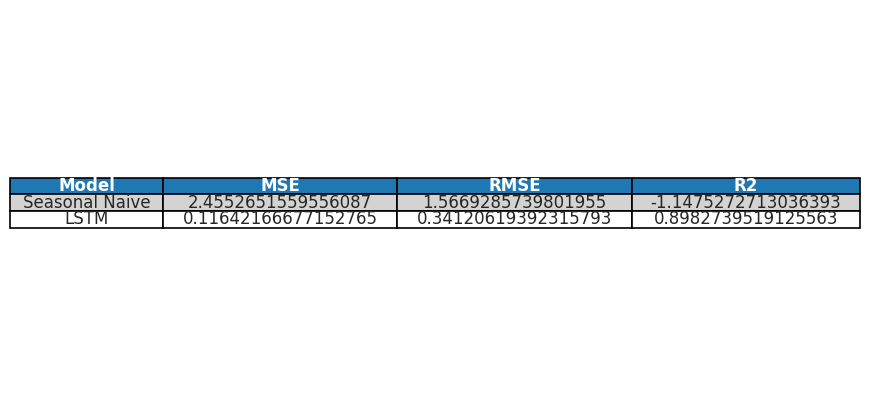

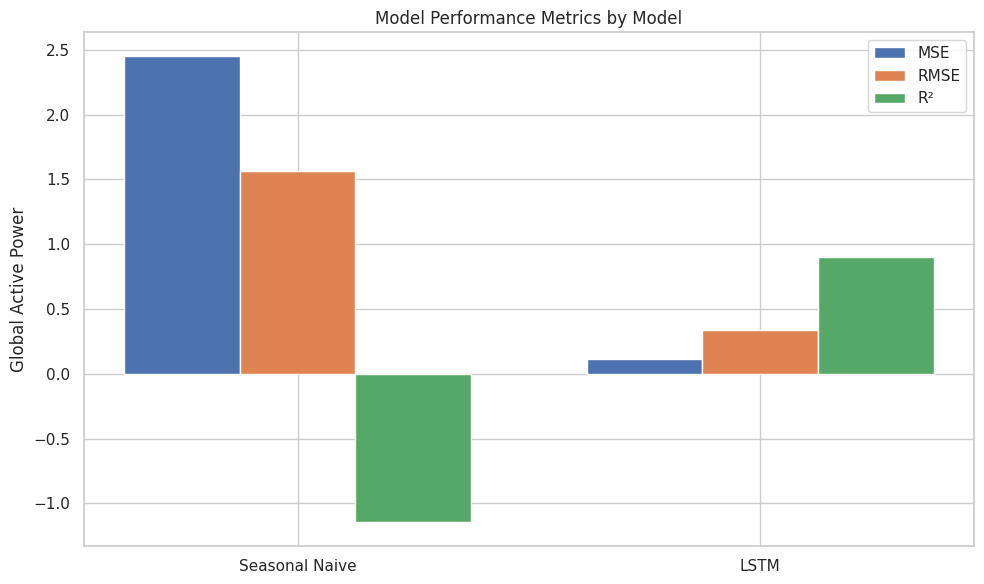

In [73]:
# Create a DataFrame from model metrics
df_metrics = pd.DataFrame(model_metrics)

# Displaying the table as a figure
fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=df_metrics.values, colLabels=df_metrics.columns, cellLoc='center', loc='center')

# Set the font size and column width
table.auto_set_font_size(False)
table.set_fontsize(12)
table.auto_set_column_width(col=list(range(len(df_metrics.columns))))

# Adding bold headers and a background color
for i, col in enumerate(df_metrics.columns):
    table[0, i].set_text_props(weight='bold', color='white')
    table[0, i].set_facecolor(colors.TABLEAU_COLORS["tab:blue"])

# Adjusting cell alignment and colors for readability
for (i, j), cell in table.get_celld().items():
    cell.set_edgecolor("black")
    cell.set_linewidth(1.2)
    if i == 0:  # Header row
        cell.set_text_props(fontweight="bold")
    else:  # Data cells
        cell.set_facecolor("white" if i % 2 == 0 else "lightgrey")

plt.show()

# Plot a grouped bar chart for each metric with the models on the x-axis
fig, ax = plt.subplots(figsize=(10, 6))

# Define the bar width and positions
bar_width = 0.25
x = range(len(df_metrics['Model']))

# Plot each metric as a separate bar
ax.bar([p - bar_width for p in x], df_metrics['MSE'], width=bar_width, label='MSE')
ax.bar(x, df_metrics['RMSE'], width=bar_width, label='RMSE')
ax.bar([p + bar_width for p in x], df_metrics['R2'], width=bar_width, label='R²')

# Adding labels and titles
ax.set_xticks(x)
ax.set_xticklabels(df_metrics['Model'])
ax.set_title('Model Performance Metrics by Model')
ax.set_ylabel('Global Active Power')
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
"""
# 1. Call SARIMA Model
print("Running SARIMA Model...")
sarima_forecast = fit_sarima(train, test)

# 2. Call LSTM Model
print("\nRunning LSTM Model...")
lstm_forecast = fit_lstm(train, test)

# 3. Call Prophet Model
print("\nRunning Prophet Model...")
prophet_forecast = fit_prophet(train, test)

# Print comparison of model predictions
print("\nPredictions:")
print(f"SARIMA forecast: {sarima_forecast[:5]}")  # Print first 5 predictions
print(f"LSTM forecast: {lstm_forecast[:5]}")  # Print first 5 predictions
print(f"Prophet forecast: {prophet_forecast[:5]}")  # Print first 5 predictions
"""

In [78]:
# Converts the dataframe to csv and downloads it
df.to_csv('final_dataset.csv', index=False)
from google.colab import files
files.download('final_dataset.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>